### Question: What is the best way to fit the log model to actual data?

In the [original paper](https://arxiv.org/pdf/1901.00521.pdf), we effectively fit the model to a single data point, by taking the observed hapax-token ratio of the overall corpus, $h$, and finding the ratio $x$ at which the observation matches the theoretical hapax-token ratio: $h = \frac{1}{\ln(x)} + \frac{1}{1-x}$ . In this notebook, we'll take this as a starting point but use a third-party function to fit $(M_z, N_z)$ to TTR sampling data.

In [1]:
# bloody dependencies
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE

# custom classes
from legomena import Corpus, SPGC

In [2]:
# standard project gutenberg corpus
spgc = SPGC.getMeta()

# for now, restrict study to english-only
spgc = spgc[spgc.language == "['en']"]

# preview
spgc.head()

,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,
1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text
2,The United States Bill of Rights: The Ten Orig...,United States,NaN,NaN,['en'],158.0,"{'Civil rights -- United States -- Sources', '...",Text
3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,['en'],28.0,{'Presidents -- United States -- Inaugural add...,Text
4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809.0,1865.0,['en'],55.0,{'Consecration of cemeteries -- Pennsylvania -...,Text
5,The United States Constitution,United States,NaN,NaN,['en'],226.0,"{'United States. Constitution', 'United States...",Text


### Choosing a Book

Select a book for use as our fitting corpus.

Number of tokens (<corpus>.M): 210258
Number of types  (<corpus>.N): 16402
Legomena vector  (<corpus>.k): [   0 7197 2781 1555  872  632  439  338  303]
Frequency distribution accessible as <corpus>.fdist
Type-Token Relation data accessible as <corpus>.TTR


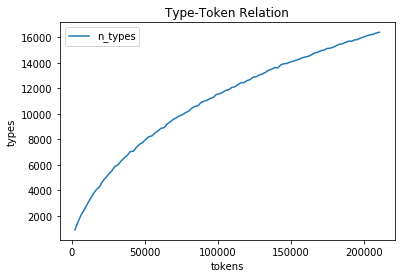

In [3]:
# spgc[spgc.title.str.contains("Bible", na = False)].head()

# bible
corpus = SPGC.get(2701)
df = corpus.buildTTRCurve()

# plot TTR curve
plt.plot(df.m_tokens, df.n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

### Single-Point Fit

Here we fit the model to a single point, using the observed hapax-type ratio of the whole corpus to infer how under- or over-representative the corpus is of an optimum sample. There are two differences between the present exercise and the [original paper](https://arxiv.org/pdf/1901.00521.pdf):

1. We use SPGC dataset instead of NLTK.
2. We use `scipy.optimize.fsolve()` to solve $H(z) = h_{obs}$ rather than the home-grown binary search.

Log model accessible as <corpus>.M_z, .N_z
Optimum sample: (M_z, N_z) =  (100192, 11583)
RMSE % = 0.004892524121194545


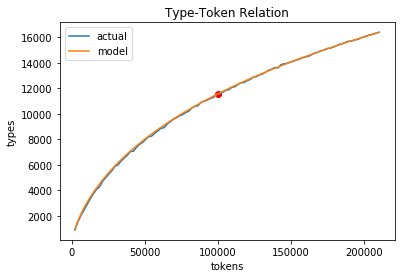

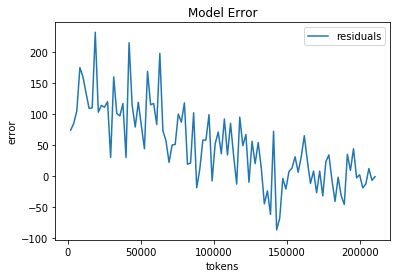

In [4]:
# run built-in optimizer
corpus.fit()
print("Optimum sample: (M_z, N_z) = ", (corpus.M_z, corpus.N_z))
m = corpus.TTR.m_tokens
n_obs = corpus.TTR.n_types
n_fit, _ = corpus.predict(m)
resid = n_fit - n_obs
print("RMSE % =", np.sqrt(MSE(n_obs, n_fit))/corpus.N)

# plot solution
plt.plot(m, n_obs, label = "actual")
plt.plot(m, n_fit, label = "model")
plt.scatter([corpus.M_z], [corpus.N_z], color = "red")
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

plt.plot(m, resid, label = "residuals")
plt.title("Model Error")
plt.xlabel("tokens")
plt.ylabel("error")
plt.legend()
plt.show()

### Fit Curve to Data

The above method uses only the observed hapax-type ratio, a single number to fit the model. We expect to do better by optimizing $(M_z, N_z)$ to the TTR curve, built from 100 samplings of the corpus.

1. Call `corpus.buildTTRCurve()` to produce the (token, type) datapoints.
2. Call `corpus.fit(optimize = True)` which will use the earlier choice of $(M_z, N_z)$ as the initial guess of `scipy.optimize.curve_fit()`.

Log model accessible as <corpus>.M_z, .N_z

Optimum sample: (M_z, N_z) =  (113838, 12288)
RMSE % = 0.002774849106476705


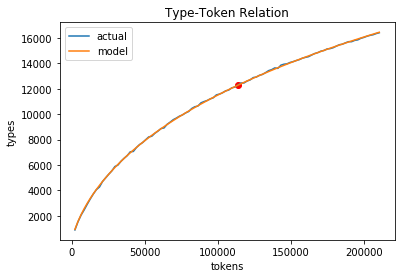

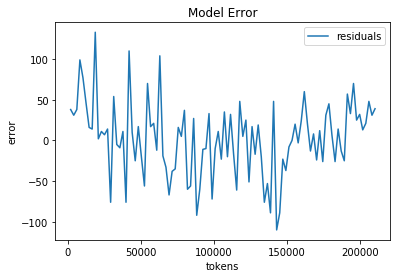

In [5]:
# fit, optimizing parameters on TTR data
corpus.fit(optimize = True)
print("\nOptimum sample: (M_z, N_z) = ", (corpus.M_z, corpus.N_z))
m = corpus.TTR.m_tokens
n_obs = corpus.TTR.n_types
n_fit, _ = corpus.predict(m)
resid = n_fit - n_obs
print("RMSE % =", np.sqrt(MSE(n_obs, n_fit))/corpus.N)

# plot solution
plt.plot(m, n_obs, label = "actual")
plt.plot(m, n_fit, label = "model")
plt.scatter([corpus.M_z], [corpus.N_z], color = "red")
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

plt.plot(m, resid, label = "residuals")
plt.title("Model Error")
plt.xlabel("tokens")
plt.ylabel("error")
plt.legend()
plt.show()

### Exploring the Error Space

There is no "well" into which the optimizer spirals. Rather, the optimum parameter space resembles a canyon following a well-defined curve on which sensible choices of $(M_z, N_z)$ lie. Part of the reason is the model asserts the optimum sample exists in the corpus, therefore the parametrization lies on the TTR curve and has only one degree of freedom.

Log model accessible as <corpus>.M_z, .N_z
Initial: (100192, 11583)
RMSE % = 0.004892524121194545
Log model accessible as <corpus>.M_z, .N_z
Final: (113838, 12288)
RMSE % = 0.002774849106476705


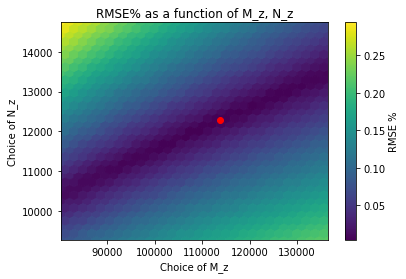

,M_z,N_z,MSE,RMSE_pct
6533,114588,12337,2158.71,0.002833
9448,116569,12432,2185.09,0.002850
6781,114085,12313,2195.70,0.002857
3763,113199,12266,2196.58,0.002857
3339,111501,12157,2209.11,0.002866
3075,112882,12226,2211.39,0.002867
7854,113407,12278,2214.46,0.002869
6043,115573,12368,2240.83,0.002886
7764,109928,12085,2338.26,0.002948
1231,115346,12386,2409.58,0.002993


In [6]:
np.random.seed(42)
df = []
m = corpus.TTR.m_tokens
n_obs = corpus.TTR.n_types

# fit using standard method first
corpus.fit()
M_z1, N_z1 = corpus.M_z, corpus.N_z
n_fit, _ = corpus.predict(m)
mse = MSE(n_obs, n_fit)
print("Initial:", (M_z1, N_z1))
print("RMSE % =", np.sqrt(mse)/corpus.N)

# then optimize the fit
corpus.fit(optimize = True)
M_z2, N_z2 = corpus.M_z, corpus.N_z
n_fit, _ = corpus.predict(m)
mse = MSE(n_obs, n_fit)
print("Final:", (M_z2, N_z2))
print("RMSE % =", np.sqrt(mse)/corpus.N)

# map out the error space over choices of M_z, N_z
for _ in range(9999):
    
    # provisional parameters
    M_z_ = int(np.random.uniform(0.8 * min(M_z1, M_z2), 1.2 * max(M_z1, M_z2)))
    N_z_ = int(np.random.uniform(0.8 * min(N_z1, N_z2), 1.2 * max(N_z1, N_z2)))
    
    # set parameters
    n_fit, _ = corpus.predict(m, M_z_, N_z_)
    mse = MSE(n_obs, n_fit)
    
    # store
    df.append((M_z_, N_z_, mse))
    
# collect data
df = pd.DataFrame(df, columns = ["M_z", "N_z", "MSE"])
df["RMSE_pct"] = np.sqrt(df.MSE)/corpus.N

# heatmap of error
x, y, z = df.M_z, df.N_z, df.RMSE_pct
plt.hexbin(x, y, C = z, gridsize = 30) #, cmap=CM.jet, bins=None)
plt.axis([x.min(), x.max(), y.min(), y.max()])
cb = plt.colorbar()
cb.set_label('RMSE %')
plt.scatter([M_z2], [N_z2], color = "red")
plt.xlabel("Choice of M_z")
plt.ylabel("Choice of N_z")
plt.title("RMSE% as a function of M_z, N_z")
plt.show()

df.sort_values("MSE").head(10)

### Is the Optimum Sample Zipf-Distributed?

Ok, we've determined that better fitting parameters can be found by minimizing the mean-squared error of 100 predictions using a stochastic process. That's not all that surprising. The question now is:

- Does the stochastic solution fall inside the confidence interval of the theoretical solution? Vice versa?
- Does a sampled corpus of size $M_z$ follow a perfect Zipf distribution?

Optimum (M_z,N_z) = (113838, 12288)


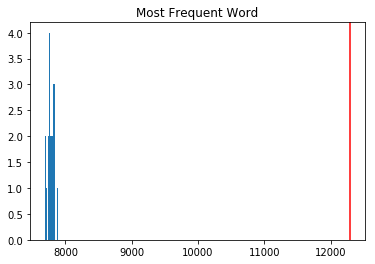

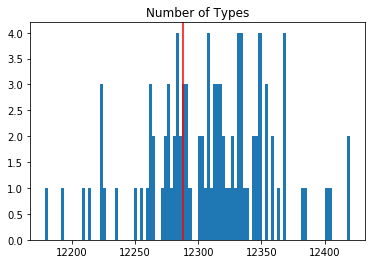

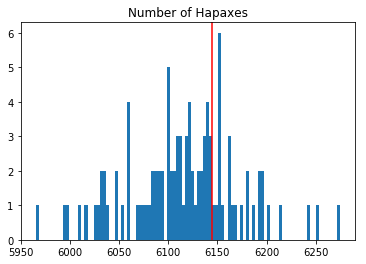

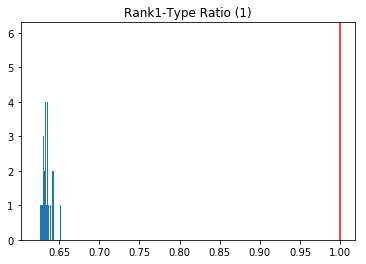

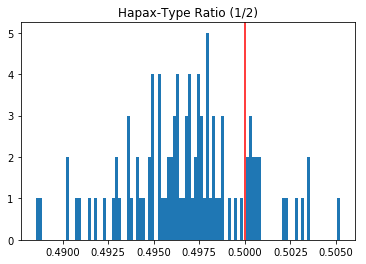

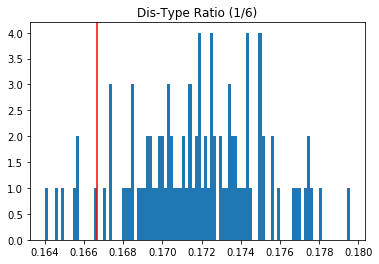

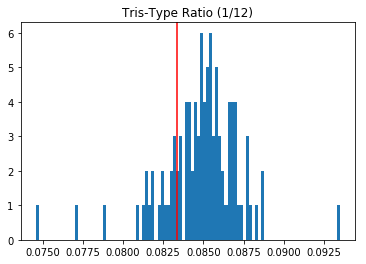

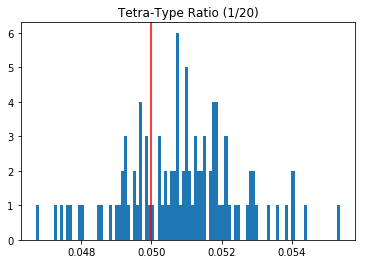

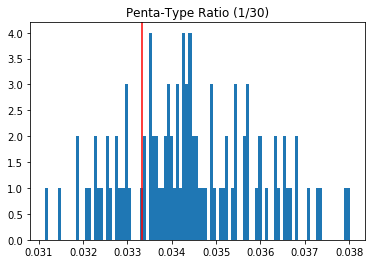

,types,hapax,dis,tris,tetra,penta,rank1,rank1_frac,hapax_frac,dis_frac,tris_frac,tetra_frac,penta_frac
0,12335,6142,2091,1042,607,433,7765,0.629510,0.497933,0.169518,0.084475,0.049210,0.035103
1,12327,6105,2168,1067,588,398,7825,0.634785,0.495254,0.175874,0.086558,0.047700,0.032287
2,12369,6148,2140,1033,666,427,7771,0.628264,0.497049,0.173013,0.083515,0.053844,0.034522
3,12313,6131,2103,1035,624,418,7816,0.634776,0.497929,0.170795,0.084058,0.050678,0.033948
4,12420,6275,2044,1081,606,454,7712,0.620934,0.505233,0.164573,0.087037,0.048792,0.036554


In [7]:
# build mini-corpus around optimal value
np.random.seed(42)
M_z, N_z = corpus.M_z, corpus.N_z
print("Optimum (M_z,N_z) =", (M_z, N_z))

df = []
for _ in range(99):
    tokens = np.random.choice(corpus.tokens, M_z, replace = False)
    minicorpus = Corpus(tokens, verbose = False)
    rank1 = len(minicorpus.k) # observed frequency of most frequent token
    types = minicorpus.N      # observed number of types
    hapax = minicorpus.k[1]   # observed number of hapax legomena
    dis   = minicorpus.k[2]   # observed number of dis   legomena
    tris  = minicorpus.k[3]   # observed number of tris  legomena
    tetra = minicorpus.k[4]   # observed number of tetra legomena
    penta = minicorpus.k[5]   # observed number of penta legomena
    df.append((types, hapax, dis, tris, tetra, penta, rank1))

# distributions of counts & ratios
df = pd.DataFrame(df, columns = ["types", "hapax", "dis", "tris", "tetra", "penta", "rank1"])
df["rank1_frac"] = df.rank1 / df.types
df["hapax_frac"] = df.hapax / df.types
df["dis_frac"]   = df.dis   / df.types
df["tris_frac"]  = df.tris  / df.types
df["tetra_frac"] = df.tetra / df.types
df["penta_frac"] = df.penta / df.types

plt.hist(df.rank1, bins = 100); plt.axvline(x = N_z, color = "red"); plt.title("Most Frequent Word"); plt.show()
plt.hist(df.types, bins = 100); plt.axvline(x = N_z, color = "red"); plt.title("Number of Types"); plt.show()
plt.hist(df.hapax, bins = 100); plt.axvline(x = N_z/2, color = "red"); plt.title("Number of Hapaxes"); plt.show()
plt.hist(df.rank1_frac, bins = 100); plt.axvline(x = 1, color = "red"); plt.title("Rank1-Type Ratio (1)"); plt.show()
plt.hist(df.hapax_frac, bins = 100); plt.axvline(x = 1/2, color = "red"); plt.title("Hapax-Type Ratio (1/2)"); plt.show()
plt.hist(df.dis_frac, bins = 100); plt.axvline(x = 1/6, color = "red"); plt.title("Dis-Type Ratio (1/6)"); plt.show()
plt.hist(df.tris_frac, bins = 100); plt.axvline(x = 1/12, color = "red"); plt.title("Tris-Type Ratio (1/12)"); plt.show()
plt.hist(df.tetra_frac, bins = 100); plt.axvline(x = 1/20, color = "red"); plt.title("Tetra-Type Ratio (1/20)"); plt.show()
plt.hist(df.penta_frac, bins = 100); plt.axvline(x = 1/30, color = "red"); plt.title("Penta-Type Ratio (1/30)"); plt.show()

# recap
df.head()

In [9]:
df.describe().T[["mean", "std"]]

,mean,std
types,12308.555556,47.437224
hapax,6115.101010,56.422512
dis,2114.181818,39.467208
tris,1043.969697,29.379451
tetra,625.949495,20.206270
penta,423.464646,18.336599
rank1,7799.979798,51.433329
rank1_frac,0.633714,0.004886
hapax_frac,0.496810,0.003242
dis_frac,0.171767,0.003252


### Conclusion

We've been able to leverage two third-party functions to improve the fitting of the model, from the `scipy.optimize` package. This helps make the result more general by increasing the model's accuracy while simultaneously outsourcing algorithmic decisions to third parties, minimizing the potential for bias.

One sobering discovery is that no optimum sample has appeared "perfectly" Zipf-distributed. This raises an odd question: How can the model be so accurate when one of its founding assumptions is wrong?

- The optimum is "more perfectly" Zipf-distributed than any other choice of $M_z$.
- A Zipf distribution with $\alpha > 1$ still manifests the same proportions of rare words, which contribute more to the signal.
- Re-deriving the model for an underlying Zipf distribution with $\alpha > 1$ will result in a cancellation of terms preserving the original result.